# Описание задачи:

Нужно кластеризовать статьи в сюжеты - объединения текстов по событиям. Источников у нас много (тысячи), и все могут в один момент писать об одном и том же событии. Эти статьи нужно схлопнуть в сюжет. 
Входными данными будут заголовок и анонс статьи. В выгрузке содержатся тексты за 48 часов. Выделим окно в 12 часов и каждый час будем двигать его вперед и проводить заново кластеризацию. 

Нужно придумать алгоритм схлопывания статей в сюжеты и, при передвижении окна вперед, объединения получившихся сюжетов со старыми, либо формирования новых.

На выходе пусть будут идентификаторы статей и номер сюжета


Вопросы / уточнения:  
А есть ли какие-то формальные требования к понятию "сюжет"?  
Разметки нет никакой, поэтому полная свобода? Или есть какие-то ограничения? Например, сколько этих сюжетов должно быть?


Ответ:  
свобода полная)  
сюжетов может быть сколько угодно (у нас сейчас именно так); в одном может быть 200 статей или одна.

возможно, добавите какой-то параметр, по которому можно будет менять схожесть статей внутри сюжета

# Логика решения:

1. Объединяю title и announce  
2. Очищаю тексты от стоп-слов (общеупотребительные слова, несущие мало смысла)
3. Лемматизация (перевод всех слов к основной форме)
4. Построение эмбеддингов для получившихся текстов
5. Расчет расстояний между новостями. Новости с маленькими расстояними попадают в один кластер
6. Близкие кластеры объединяются в один
7. Проход скользящим окном по всему датасету для кластеризации новых новостей.

# Эксплоративный анализ

In [1]:
import pandas as pd
import re, datetime
import numpy as np
from tqdm import tqdm

In [2]:
# Требуется переименовать исходный csv-файл в articles.csv
df = pd.read_csv('articles.csv')
df

,article_id,update_date,source_id,title,announce
0,109848931,2021-07-31 21:01:11,2922,Нарышкин заявил о фактах продвижения россиянам...,"Российские спецслужбы фиксируют факты, когда г..."
1,109848951,2021-07-31 21:03:08,2241,Золото нашей сборной в фехтовании и победа «Ло...,"Главные новости дня — все, что стало известно ..."
2,109848952,2021-07-31 21:03:08,2241,Крыховяк отказался тренироваться накануне матч...,В «СЭ» вышел материал нашего обозревателя Игор...
3,109848971,2021-07-31 21:03:08,1557,Из кокни в сэры: Майкл Кейн поделился секретам...,Как сын уборщицы и грузчика стал знаменитым бр...
4,109848974,2021-07-31 21:03:08,1557,«Надо оставить большое наследие в нашем виде с...,Олимпийский чемпион по тхэквондо Владислав Лар...
...,...,...,...,...,...
148901,110340220,2021-08-11 12:17:10,4120,Россия может впервые обогнать Швейцарию по экс...,Объем экспорта шоколада из России по итогам 20...
148902,110343744,2021-08-11 13:12:08,4120,Cian.ru планирует до конца года провести IPO,Сервис объявлений о продаже и аренде имущества...
148903,110343895,2021-08-11 13:14:09,405,Ковид в Казахстане: подъем заболеваемости связ...,Из-за сложной ситуации с коронавирусом с понед...
148904,110350544,2021-08-11 15:10:10,4120,"Глава Xsolla уволил часть сотрудников, проанал...",В Twitter появился скриншот письма от основате...


<AxesSubplot:xlabel='update_date'>

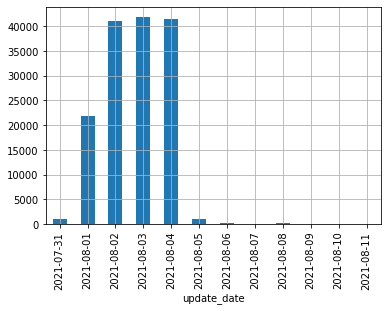

In [3]:
# Распределение по датам:

df['update_date'] = pd.to_datetime(df['update_date'])  # Привожу к дате-времени
df.groupby(df['update_date'].dt.date).size().plot.bar(rot=90, grid=True)

In [4]:
# Данные до 1 августа и после 4 августа считаем выбросами и удаляем их

df = df[(df['update_date'] >= '2021-08-01') & (df['update_date'] < '2021-08-05')]
df = df.sort_values(by='update_date')

<AxesSubplot:xlabel='update_date'>

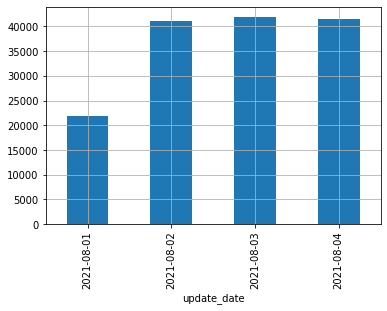

In [5]:
# Вот теперь более-менее норм, хотя 1 августа выглядит подозрительно:

df.groupby(df['update_date'].dt.date).size().plot.bar(rot=90, grid=True)

In [6]:
# Общая статистика (того, что осталось):

print('Размер датасета, строк:', len(df))
df['title_words_n'] = df['title'].apply(lambda x: len(str(x).split()))
df['announce_words_n'] = df['announce'].apply(lambda x: len(str(x).split()))
print('Среднее количество слов в title:', df['title_words_n'].mean().round(2))
print('Среднее количество слов в announce:', df['announce_words_n'].mean().round(2))
del df['title_words_n']
del df['announce_words_n']

Размер датасета, строк: 146373
Среднее количество слов в title: 9.37
Среднее количество слов в announce: 22.18


# Подготовка текстов

In [7]:
from pymystem3 import Mystem  # for lemmatization
mystem = Mystem() 

In [8]:
# Stop words
# Все предлоги русского языка
prepositions = ['а-ля', 'без', 'безо', 'без ведома', 'благодаря', 'близ', 'в', 'во', 'в адрес', 'в аспекте', \
                'в виде', 'в глазах', 'в глубь', 'в деле', 'в дополнение к', 'в духе', 'в завершение', \
                'в зависимости от', 'в заключение', 'в знак', 'в интересах', 'в качестве', 'в лице', 'в меру', \
                'в направлении', 'в направлении к', 'в направлении ко', 'в нарушение', 'в области', 'в обмен на', \
                'в обстановке', 'в обход', 'в ответ на', 'в отдалении от', 'в отличие от', 'в отношении', \
                'в память', 'в плане', 'в пользу', 'в порядке', 'в предвидении', 'в предвкушении', \
                'в преддверии', 'в присутствии', 'в продолжение', 'в противность', 'в противовес', \
                'в противоположность', 'в процессе', 'в разрезе', 'в районе', 'в рамках', 'в рассуждении', \
                'в расчете на', 'в результате', 'в роли', 'в ряду', 'в свете', 'в связи с', 'в связи со', \
                'в силу', 'в случае', 'в смысле', 'в согласии с', 'в сообществе с', 'в соответствии с', \
                'в соответствии со', 'в сопоставлении с', 'в сопровождении', 'в составе', 'в сравнении с', \
                'в сравнении со', 'в стороне от', 'в сторону', 'в сфере', 'в счет', 'в течение', 'в угоду', \
                'в унисон с', 'в условиях', 'в ущерб', 'в форме', 'в ходе', 'в целях', 'в честь', 'в числе', \
                'в число', 'вблизи', 'вблизи от', 'вверху', 'ввиду', 'вглубь', 'вдалеке от', 'вдали', 'вдали от', \
                'вдобавок к', 'вдобавок ко', 'вдогон', 'вдогонку', 'вдоль', 'вдоль по', 'взамен', 'включая', \
                'вкось', 'вкруг', 'вместе с', 'вместе со', 'вместо', 'вне', 'вне зависимости от', 'внизу', \
                'внутри', 'внутрь', 'вовнутрь', 'во время', 'во главе', 'во главе с', 'во главе со', \
                'во избежание', 'во изменение', 'во имя', 'во исполнение', 'во славу', 'возле', 'вокруг', \
                'волею', 'вопреки', 'вперед', 'впереди', 'вплоть до', 'впредь до', 'вразрез', 'времен', 'вроде', \
                'вслед', 'вослед', 'вслед за', 'вследствие', 'выше', 'для', 'до', 'за', 'за исключением', \
                'за счет', 'заботами', 'из', 'изо', 'из числа', 'из-за', 'из-под', 'из-подо', 'изнутри', \
                'именем', 'имени', 'исключая', 'исходя из', 'к', 'ко', 'к числу', 'касаемо', 'касательно', \
                'кончая', 'кроме', 'кругом', 'между', 'меж', 'промеж', 'промежду', 'между', 'меж', 'промеж', \
                'промежду', 'мимо', 'минуя', 'на', 'на базе', 'на благо', 'на глазах у', 'на грани', 'на имя', \
                'на манер', 'на основании', 'на основе', 'на почве', 'на правах', 'на предмет', 'на протяжении', \
                'на пути', 'на пути к', 'на пути ко', 'на путях', 'на путях к', 'на путях ко', 'на радость', \
                'на случай', 'на смену', 'на стороне', 'на сторону', 'на уровне', 'на фоне', 'наверху', \
                'навстречу', 'над', 'надо', 'назади', 'накануне', 'наперекор', 'наперерез', 'наперехват', \
                'наподобие', 'напротив', 'наравне с', 'наравне со', 'наряду с', 'наряду со', 'насупротив', \
                'насчет', 'начиная', 'начиная от', 'начиная с', 'начиная со', 'не без', 'не в пример', \
                'не говоря о', 'не говоря об', 'не говоря обо', 'не до', 'не считая', 'невдалеке от', \
                'невзирая на', 'недалеко', 'недалеко от', 'независимо', 'независимо от', 'неподалеку от', \
                'несмотря на', 'ниже', 'о', 'об', 'обо', 'обок', 'обочь', 'около', 'окрест', 'от', 'ото', \
                'от имени', 'от лица', 'относительно', 'памяти', 'перед', 'передо', 'пред', 'предо', \
                'перед лицом', 'плюс к', 'плюс ко', 'по', 'по адресу', 'по аналогии с', 'по аналогии со', \
                'по вине', 'по истечении', 'по линии', 'по мере', 'по направлению', 'по направлению к', \
                'по направлению ко', 'по отношению к', 'по отношению ко', 'по поводу', 'по праву', 'по примеру', \
                'по причине', 'по прошествии', 'по пути', 'по случаю', 'по сравнению с', 'по сравнению со', \
                'по стопам', 'по части', 'по-за', 'по-над', 'по-под', 'поблизости', 'поблизости от', 'поверх', \
                'погодя', 'под', 'подо', 'под видом', 'под знаком', 'под предлогом', 'под председательством', \
                'под эгидой', 'подле', 'подобно', 'позади', 'позднее', 'поздней', 'позже', 'помимо', \
                'поодаль от', 'поперед', 'поперек', 'порядка', 'посереди', 'посередине', 'посередке', 'посередь', \
                'после', 'посреди', 'посредине', 'посредством', 'превыше', 'прежде', 'при', 'при всей', \
                'при всем', 'при всех', 'при помощи', 'при посредстве', 'при условии', 'применительно к', \
                'применительно ко', 'про', 'против', 'противно', 'путем', 'ради', 'раньше', 'рядом с', 'рядом со', \
                'с', 'со', 'с ведома', 'с помощью', 'с учетом', 'с целью', 'сбоку', 'сбоку от', 'сверх', 'сверху', \
                'свыше', 'середь', 'сзади', 'силами', 'сквозь', 'следом за', 'смотря по', 'снаружи', 'снизу', \
                'со стороны', 'совместно с', 'совместно со', 'совокупно с', 'согласно', 'согласно с', \
                'согласно со', 'сообразно', 'сообразно с', 'сообразно со', 'сообща с', 'сообща со', \
                'соответственно', 'соответственно с', 'соответственно со', 'соразмерно', 'соразмерно с', \
                'соразмерно со', 'спереди', 'спустя', 'сравнительно с', 'сравнительно со', 'среди', 'средь', \
                'сродни', 'судя по', 'супротив', 'считая', 'типа', 'у', 'ценой', 'ценою', 'через', 'черезо', \
                'чрез', 'чрезо', 'что до']

# Все союзы русского языка
conjunctions = ['а', 'а ведь', 'а еще', 'а и то', 'а именно', 'а не то', 'а не то что', 'а не только', \
                'а равно и', 'а также', 'а то', 'а то и', 'абы', 'аж', 'ажно', 'ай', 'аки', 'али', 'аль', \
                'ан', 'аще', 'благо', 'благо что', 'благодаря тому что', 'благодаря чему', 'буде', 'будто' \
                'будто бы', 'будь то', 'в знак того что', 'в надежде на то что', 'в отношении того что', \
                'в подтверждение того что', 'в противном случае', 'в расчете на то что', 'в результате того что', \
                'в результате чего', 'в связи с тем что', 'в связи с чем', 'в силу того что', 'в случае если', \
                'в то время как', 'в том духе, что', 'в том отношении, что', 'в том смысле, что', 'в том числе', \
                'в том числе и', 'ввиду того что', 'ведь', 'вместо того чтоб', 'вместо того чтобы', \
                'во всяком случае', 'во имя того чтобы', 'вопреки тому что', 'вплоть до того что', 'впрочем', \
                'вроде бы', 'вроде как', 'вроде того что', 'вроде того чтоб', 'вроде того чтобы', 'все', \
                'все ж таки', 'все же', 'все равно как', 'все-таки', 'вследствие того что', 'вследствие чего', \
                'где б ни', 'где бы ни', 'где ни', 'да', 'да ведь', 'да еще', 'да еще и', 'да и', 'да и то', \
                'да как', 'дабы', 'даже', 'даром что', 'для того чтоб', 'для того чтобы', 'до тех пор пока', \
                'до того как', 'добро', 'добро бы', 'доколе', 'доколь', 'докуда', 'едва', 'едва лишь', \
                'едва только', 'ежели', 'если', 'если б', 'если б и', 'если б не', 'если бы', 'если бы и', \
                'если бы не', 'если не', 'еще', 'ж', 'же', 'за исключением того что', 'за счет того что', \
                'затем что', 'затем чтоб', 'затем чтобы', 'зато', 'значит', 'и', 'и то', 'ибо', 'из-за того что', \
                'или', 'иль', 'именно', 'ин', 'иначе', 'исходя из того что', 'итак', 'к тому ж', 'к тому же', \
                'кабы', 'как', 'как будто', 'как будто бы', 'как бы', 'как бы ни', 'как вдруг', 'как все равно', \
                'как если бы', 'как и', 'как ни', 'как скоро', 'как только', 'какой бы ни', 'какой ни', 'когда', \
                'когда б', 'когда б не', 'когда б ни', 'когда бы', 'когда бы не', 'когда бы ни', 'когда ни', \
                'коли', 'коль', 'коль скоро', 'кроме как', 'кроме того что', 'кто б ни', 'кто бы ни', 'кто ни', \
                'куда б ни', 'куда бы ни', 'куда ни', 'ли', 'либо', 'лишь', 'лишь бы', 'лишь бы только', \
                'лишь только', 'лишь только б', 'лишь только бы', 'ль', 'мало того что', 'меж тем как', \
                'между тем как', 'на случай если', 'на том основании что', 'на тот случай если', 'на что', \
                'наподобие того как', 'наподобие того что', 'напротив', 'насчет того что', 'начиная с того что',\
                'не то', 'не то что', 'невзирая на то что', 'нежели', 'независимо от того что', \
                'несмотря на то что', 'нет', 'нет бы', 'нет того, чтоб', 'нет того, чтобы', 'нет чтоб', \
                'нет чтобы', 'нешто', 'ни', 'но', 'но и', 'но и то', 'ну', 'однако', 'относительно того что', \
                'оттого что', 'отчего', 'перед тем как', 'по мере того как', 'по поводу того что', \
                'по причине того, что', 'по случаю того что', 'по той причине что', 'по тому поводу, что', \
                'под предлогом того, что', 'под предлогом, что', 'под тем предлогом, что', 'подобно тому как', \
                'поелику', 'пока', 'пока не', 'покамест', 'покаместь', 'покуда', 'покудова', 'помимо того что', \
                'понеже', 'поскольку', 'после того как', 'после чего', 'постольку', 'постольку поскольку', \
                'потому', 'потому как', 'потому что', 'почему', 'правда', 'прежде нежели', 'прежде чем', \
                'при всем том', 'при всем том что', 'при том что', 'притом', 'причем', 'промеж тем', 'просто', \
                'пускай', 'пускай бы', 'пусть', 'пусть бы', 'равно', 'равно как', 'равно как и', \
                'ради того чтоб', 'ради того чтобы', 'раз', 'разве', 'раньше чем', 'ровно', 'ровно бы', \
                'с таким расчетом, чтоб', 'с таким расчетом, чтобы', 'с тем расчетом, чтоб', \
                'с тем расчетом, чтобы', 'с тем чтоб', 'с тем чтобы', 'с тех пор как', 'с той разницей что', \
                'с той целью, чтоб', 'с той целью, чтобы', 'с целью чтоб', 'с целью чтобы', 'сиречь', \
                'сколь бы ни', 'сколь ни', 'сколько б ни', 'сколько бы ни', 'сколько ни', 'следовательно', \
                'следственно', 'словно', 'словно б', 'словно бы', 'словно как', 'судя по тому что', 'так', \
                'так же', 'так же как', 'так же как и', 'так и', 'так как', 'так что', 'таким образом', 'тем', \
                'тем более что', 'тем не менее', 'теперь', 'то', 'то бишь', 'то есть', 'тогда как', 'тоже', \
                'токмо', 'только', 'только б', 'только бы', 'только лишь', 'только что', 'точно', 'точно бы', \
                'уж на что', 'хоть', 'хоть бы', 'хоть и', 'хотя', 'хотя б', 'хотя бы', 'хотя и', 'чем', 'чем бы', \
                'что', 'чтоб', 'чтобы', 'чуть', 'чуть только', 'яко', 'якобы']

# Все частицы русского языка
particles = ['а', 'а вот', 'а вот и', 'а если', 'а если б', 'а если бы', 'а как же', 'а не только что', \
             'а ну как', 'а то', 'а то как же', 'а то что ж', 'а то что же', 'а уж', 'а что', 'а что если', \
             'а что ж', 'а что же', 'а что как', 'абы', 'авось', 'ага', 'аж', 'ажно', 'ай да', 'ай-я-яй', 'али', \
             'аль', 'аминь', 'ан', 'ан глядь', 'ан нет', 'ась', 'б', 'безусловно', 'бишь', 'благоволите', \
             'благодарствуйте', 'будет', 'будто', 'будто бы', 'бы', 'было', 'было б', 'было бы', 'в особенности', \
             'валяй', 'валяйте', 'вдруг', 'ведь', 'верно', 'вероятно', 'вестимо', 'вишь', 'во всяком случае', \
             'во-во', 'возможно', 'вон', 'вон как', 'вон какой', 'вона', 'вообще', 'вот', 'вот бы', 'вот еще', \
             'вот и', 'вот и все', 'вот именно', 'вот разве только', 'вот так', 'вот те и', 'вот тебе и', \
             'вот то-то что', 'вот только б', 'вот только бы', 'вот уж', 'вот уже', 'вот что', 'вот это', \
             'вот-вот', 'впрямь', 'врешь', 'вроде', 'вроде бы', 'вроде как', 'вряд', 'вряд ли', 'все', 'все ж', \
             'все ж таки', 'все же', 'все равно', 'все равно что', 'все-таки', 'всего', 'всего лишь', \
             'всего-навсего', 'где', 'где там', 'где тут', 'где уж', 'где уж там', 'где уж тут', 'гляди', \
             'глядишь', 'глядь', 'годится', 'да', 'да ведь', 'да вот', 'да еще как', 'да еще какой', 'да и все', \
             'да и только', 'да мало ли', 'да ну', 'да чего уж', 'да что ж', 'да что же', 'да что там', \
             'да чтоб', 'да чтобы', 'давай', 'давайте', 'даже', 'дай', 'де', 'действительно', 'дескать', \
             'диви бы', 'добре', 'добро', 'добро бы', 'довольно', 'допустим', 'достаточно', 'дудки', 'едва ли', \
             'едва ли не', 'едва ль', 'едва ль не', 'едва не', 'единственно', 'если', 'если б', 'если бы', \
             'естественно', 'есть', 'еще', 'еще бы', 'еще как', 'еще какой', 'ж', 'же', 'железно', 'закачаешься', \
             'знай', 'и', 'и без того', 'и вот', 'и впрямь', 'и все', 'и есть', 'и ну', 'и так', 'и то', \
             'и то правда', 'и того', 'и только', 'и точно', 'и что же', 'ибн', 'идет', 'или', 'или-или', 'иль', \
             'именно', 'ин', 'инда', 'ино', 'исключительно', 'исполать', 'ить', 'ишь', 'ишь ведь', 'ишь ты', \
             'кабы', 'кажется', 'кажись', 'как', 'как будто', 'как будто бы', 'как бы', 'как бы не так', \
             'как же', 'как раз', 'как сказать', 'как-никак, а', 'какое', 'когда', 'когда б', 'когда бы', \
             'конечно', 'кто-кто, а', 'куда', 'куда там', 'куда тут', 'куда уж', 'куда уж там', 'куда уж тут', \
             'ладно', 'ладушки', 'лады', 'ли', 'лично', 'лишь', 'лишь бы', 'лишь только', 'лучше', 'ль', \
             'мало ли', 'мало ли что', 'мерси', 'мол', 'на', 'на тебе', 'на-тка', 'навряд', 'навряд ли', \
             'накось', 'накося', 'наоборот', 'напротив', 'нате', 'натурально', 'не', 'не более', 'не больше', \
             'не иначе', 'не иначе как', 'не кто иной как', 'не менее', 'не меньше', 'не просто', \
             'не раньше как', 'не раньше чем', 'не так ли', 'не то чтоб', 'не то чтобы', 'не только', \
             'не только что', 'не что иное, как', 'не-а', 'небось', 'неравно', 'несомненно', 'нет', \
             'нет как нет', 'нет-нет да и', 'нетушки', 'неужели', 'неужто', 'нехай', 'нешто', 'ни', 'ни-ни', \
             'ни-ни-ни', 'никак', 'никак нет', 'нисколько', 'ничего', 'ничуть', 'но', 'ну', 'ну а если', \
             'ну а как же', 'ну вот', 'ну вот еще', 'ну вот и все', 'ну вот что', 'ну да', 'ну и', 'ну и что', \
             'ну и что ж', 'ну и что же', 'ну как', 'ну как же', 'ну так как', 'ну так как же', 'ну уж', \
             'ну что', 'ну что ж', 'ну что же', 'ну-ну', 'ну-с', "о'кей", 'один', 'одна', 'одни', 'одно', \
             'ой ли', 'окей', 'оно', 'опять же', 'опять-таки', 'отлично', 'отнюдь', 'очевидно', 'плюс-минус', \
             'по крайней мере', 'по-видимому', 'поди', 'подумаешь', 'пожалуй', 'пожалуйста', 'пожалуйте', \
             'полно', 'полноте', 'положим', 'понятно', 'попросту', 'похоже', 'почему', 'почти что', 'правда', \
             'право', 'превосходно', 'предположим', 'прекрасно', 'привет', 'просто', 'просто-напросто', 'прямо', \
             'прямо-таки', 'пускай', 'пускай бы', 'пусть', 'пусть бы', 'раз', 'разве', 'разве только', \
             'разве что', 'разумеется', 'рассказывай', 'решительно', 'ровно', 'ровно бы', 'салют', 'само собой', \
             'само собою', 'се', 'себе', 'слабо', 'славно', 'словно', 'словно б', 'словно бы', 'слушаю', \
             'слушаюсь', 'слышь', 'смотри', 'смотрите', 'собственно', 'спасибо', 'спасибочко', 'страсть', \
             'счастливо', 'так', 'так вот', 'так и', 'так и быть', 'так и есть', 'так и так', 'так и так, мол', \
             'так или иначе', 'так как', 'так как же', 'так ли', 'так нет', 'так нет вот', 'так нет же', \
             'так точно', 'так-с', 'так-таки', 'так, мол и так', 'также', 'таки', 'такое', 'там', 'те', 'тебе', \
             'тем более', 'тем не менее', 'тем паче', 'то', 'то есть', 'то-то', 'то-то что', 'того', 'тоже', \
             'тоже мне', 'токмо', 'только', 'только б', 'только бы', 'только и', 'только и всего', \
             'только лишь', 'только что', 'только что вот', 'только-то', 'точнее', 'точно', 'точно бы', \
             'точно как', 'точно так', 'трах', 'трах-тарарах', 'тут', 'тэк-с', 'угодно', 'угу', 'уж', \
             'уж кто-кто, а', 'уж что-что, а', 'уже', 'ужели', 'ужель', 'ужо', 'факт', 'фигушки', 'фон-', 'фра', \
             'хай', 'хватит', 'хорошо', 'хоть', 'хоть бы', 'хоть бы и', 'хотя', 'хотя б', 'хотя бы', 'хуже того', \
             'чай', 'чего', 'что б', 'что бы', 'что вы', 'что если', 'что ж', 'что же', 'что за', 'что ли', \
             'что ль', 'что так', 'что там', 'что ты', 'что-нибудь', 'что-то', 'что-что, а', 'чтоб', 'чтобы', \
             'чудесно', 'чудно', 'чуть было не', 'чуть ли не', 'чуть не', 'шабаш', 'эва', 'эво', 'эвон', 'эвона', \
             'эвоно', 'эвось', 'эвося', 'эвот', 'эге', 'эк', 'эка', 'эка беда', 'эко', 'эн', 'этак', 'это', \
             'якобы', 'ясненько', 'ясно']

# Все междометья  русского языка
interjections = ['а', 'а ну', 'а ну тебя', 'а ну-ка', 'а туда же', 'ага', 'агу', 'адью', 'ай', 'ай-ай-ай', \
                 'ай-люли', 'айда', 'але', 'алле', 'аллилуйя', 'алло', 'аминь', 'апорт', 'апчхи', 'атанде', \
                 'атас', 'ату', 'ау', 'ах', 'ах да', 'ах ты', 'ба', 'бабах', 'баиньки', 'баиньки-баю', 'бай', \
                 'бай-бай', 'баста', 'батюшки', 'бах', 'бац', 'баю', 'баю-бай', 'баю-баюшки-баю', 'баюшки', \
                 'баюшки-баю', 'бе', 'бис', 'блеск', 'блин', 'бля', 'блядь', 'боже', 'бом', 'брависсимо', 'браво', \
                 'брр', 'брысь', 'бряк', 'бултых', 'буль', 'бум', 'бух', 'бывай', 'верть', 'вжик', 'виват', \
                 'видал', 'видали', 'вира', 'вист', 'во', 'вон', 'вон как', 'вон оно как', 'вон оно что', \
                 'вон что', 'вона', 'вот как', 'вот оно как', 'вот оно что', 'вот так да', 'вот так так', \
                 'вот так-то', 'вот те на', 'вот те раз', 'вот тебе на', 'вот тебе раз', 'вот то-то', \
                 'вот то-то и оно', 'вот что', 'вот это да', 'все', 'всего', 'всего доброго', 'всего наилучшего', \
                 'всего хорошего', 'га', 'гав', 'гайда', 'ге', 'гей', 'геть', 'гип-гип', 'гляди', 'глядите', 'гм', \
                 'го', 'гой', 'гоп', 'гопля', 'горе', 'горько', 'господи', 'грох', 'гули', 'гулиньки', 'гуль', \
                 'гуля', 'да здравствует', 'да ну', 'да чего там', 'давай-давай', 'даешь', 'дерг', 'дзинь', \
                 'динь-динь', 'до встречи', 'до завтра', 'до свидания', 'до свиданьица', 'до свиданья', 'долой', \
                 'дон', 'дрыг', 'дудочки', 'дьявол', 'ей', 'ей-богу', 'ей-ей', 'ей-же-ей', 'еще чего', 'ж-ж', \
                 'жжик', 'з-з', 'звяк', 'здорово', 'здравствуй', 'здравствуйте', 'здрасьте', 'зырк', 'и', \
                 'и на вот', 'ик', 'их', 'к черту', 'к чертям', 'кап', 'караул', 'ква', 'квак', 'кис', 'киш', \
                 'круть', 'кря', 'ку-ку', 'кувырк', 'кукареку', 'курлы', 'кхе', 'кхм', 'кш', 'кыш', 'лататы', \
                 'лели', 'ловко', 'люли', 'ля-ля', 'м-да', 'майна', 'мамоньки', 'мамочки', 'марш', 'марш-марш', \
                 'матушки', 'мать', 'мах', 'ме', 'мельк', 'мля', 'морг', 'му', 'мур', 'мяу', 'н-да', 'на вот', \
                 'на здоровье', 'на шарап', 'надо ж', 'надо же', 'наконец-то', 'не за что', 'ни гугу', \
                 'ничего себе', 'но', 'ну', 'ну и ну', 'ну тебя', 'ну то-то ж', 'ну то-то же', 'ну-ка', 'ну-ну', \
                 'ну-тка', 'нуте', 'нуте-ка', 'нуте-с', 'о', 'о-го-го', 'ого', 'ого-го', 'однако', 'ой', 'оп', \
                 'опля', 'ох', 'ох ты', 'охохоньки', 'охохонюшки', 'охти', 'пардон', 'пас', 'паф', 'пафф', 'пиль', \
                 'пиф-паф', 'пли', 'плюх', 'побоку', 'пока', 'полундра', 'порх', 'проклятие', 'проклятье', \
                 'прости', 'прости-прощай', 'прочь', 'прощай', 'прощайте', 'прыг', 'прыск', 'прысь', 'пшик', \
                 'пых', 'свят-свят-свят', 'скок', 'скок-поскок', 'скрип', 'снова-здорово', 'стоп', 'стук', \
                 'та-та-та', 'тарарах', 'тары-бары', 'те-те', 'тега', 'ти-ти-ти', 'тик', 'тик-так', 'то-то вот', \
                 'то-то вот и есть', 'то-то вот оно и есть', 'то-то ж', 'то-то же', 'то-то и есть', 'то-то и оно', \
                 'толк', 'топ', 'тпрр', 'тпру', 'тпрюси', 'тра-та-та', 'трах', 'трах-тарарах', 'трень-брень', \
                 'трр', 'трух-трух', 'трюх-трюх', 'тсс', 'тубо', 'туда же', 'тук', 'тфу', 'тырк', 'тьфу', 'тю', \
                 'тю-тю', 'тюк', 'тяв', 'тяп', 'у', 'у-лю-лю', 'у-у', 'уа', 'увы', 'узы', 'ура', 'усь', 'ути', \
                 'уть', 'утя', 'уф', 'ух', 'ух ты', 'фа', 'фай', 'фас', 'фасс', 'фи', 'фить', 'фора', 'фу', \
                 'фу ты', 'фу-ты', 'фук', 'фыр', 'фью', 'фью-фью', 'фьють', 'фю', 'фю-фю', 'фюить', 'ха', 'ха-ха', \
                 'ха-ха-ха', 'хвать', 'хе', 'хе-хе', 'хе-хе-хе', 'хи', 'хи-хи', 'хи-хи-хи', 'хлесть', 'хлобысть', \
                 'хлоп', 'хлысть', 'хлюп', 'хляск', 'хлясть', 'хм', 'хны', 'хо', 'хо-хо', 'хо-хо-хо', 'хоп', \
                 'хруп', 'хрусть', 'хрю', 'хрюк', 'хрясть', 'хы', 'цап', 'цап-царап', 'царап', 'цвинь', 'цвирик', \
                 'цвирк', 'цок', 'цоп', 'цып', 'цыц', 'цыцте', 'чебурах', 'чего', 'чего там', 'черк', 'черт', \
                 'чив', 'чив-чив', 'чик', 'чик-чирик', 'чирик', 'чирк', 'чих', 'чмок', 'чок', 'чорт', 'что вы', \
                 'что ты', 'чу', 'чур', 'чур-чура', 'чух', 'чхи', 'чш', 'чш-ш', 'ш-ш', 'ша', 'шарах', 'шарк', \
                 'шасть', 'шварк', 'швырк', 'швырь', 'ши', 'шлеп', 'шмыг', 'шмяк', 'шорк', 'шу-шу', 'шурк', \
                 'шухер', 'щелк', 'щип', 'э', 'э-ге-ге', 'э-хе-хе', 'эва', 'эво', 'эвон', 'эврика', 'эге', \
                 'эге-ге', 'эгей', 'эй', 'экось', 'экося', 'эх', 'эх вы', 'эх ты', 'эх-ма', 'эхва', 'эхма', 'юрк']

# Все местоимения русского языка
pronouns = ['аз', 'вам', 'вами', 'вас', 'ваш', 'ваша', 'ваше', 'ваше', 'вашего', 'вашей', 'вашей', 'вашем', \
            'вашему', 'вашею', 'ваши', 'вашим', 'вашими', 'ваших', 'вашу', 'весь', 'вон', 'вона', 'вот что', \
            'вот', 'все', 'всего', 'всей', 'всем', 'всеми', 'всему', 'всех', 'всею', 'всея', 'всю', 'вся', 'всяк', \
            'всякая', 'всякие', 'всякий', 'всяким', 'всякими', 'всяких', 'всякого', 'всякое', 'всякой', 'всяком', \
            'всякому', 'всякою', 'всяческая', 'всяческие', 'всяческий', 'всяческим', 'всяческими', 'всяческих', \
            'всяческого', 'всяческое', 'всяческой', 'всяческом', 'всяческому', 'всяческою', 'всяческую', 'вы', \
            'где-либо', 'где-нибудь', 'где-то', 'где', 'докель', 'докуда-нибудь', 'докуда-то', 'докуда', 'досель', \
            'досюда', 'друг друга', 'друг друге', 'друг другом', 'друг другу', 'друг дружке', 'друг дружкой', \
            'друг дружку', 'другая', 'другие', 'другим', 'другими', 'других', 'другого', 'другое', 'другой', \
            'другом', 'другому', 'другою', 'другую', 'его', 'ее', 'ей', 'ему', 'ею', 'зачем-либо', 'зачем-нибудь', \
            'зачем-то', 'зачем', 'здесь', 'и то и се', 'и того и сего', 'иже', 'известный', 'им', 'ими', 'иная', \
            'иного', 'иное', 'иной', 'ином', 'иному', 'иною', 'иную', 'иные', 'иным', 'иными', 'иных', 'их', \
            'каждая', 'каждого', 'каждое', 'каждой', 'каждой', 'каждом', 'каждому', 'каждою', 'каждую', 'каждые', \
            'каждый', 'каждым', 'каждыми', 'каждых', 'как таковой', 'какая бы то ни было', 'какая попало', \
            'какая придется', 'какая такая', 'какая там еще', 'какая-либо', 'какая-нибудь', 'какая-то', 'какая', \
            'какие бы то ни было', 'какие попало', 'какие придется', 'какие такие', 'какие там еще', 'какие-либо', \
            'какие-нибудь', 'какие-то', 'какие', 'каким бы то ни было', 'каким попало', 'каким придется', \
            'каким таким', 'каким там еще', 'каким-либо', 'каким-нибудь', 'каким-то', 'каким', \
            'какими бы то ни было', 'какими попало', 'какими придется', 'какими такими', 'какими там еще', \
            'какими-либо', 'какими-нибудь', 'какими-то', 'какими', 'каких бы то ни было', 'каких попало', \
            'каких придется', 'каких таких', 'каких там еще', 'каких-либо', 'каких-нибудь', 'каких-то', 'каких', \
            'каков', 'какова', 'каковая', 'каково', 'какового', 'каковое', 'каковой', 'каковом', 'каковому', \
            'каковую', 'каковы', 'каковые', 'каковым', 'каковыми', 'каковых', 'какого бы то ни было', \
            'какого попало', 'какого придется', 'какого такого', 'какого там еще', 'какого-либо', 'какого-нибудь', \
            'какого-то', 'какого', 'какое бы то ни было', 'какое попало', 'какое придется', 'какое такое', \
            'какое там еще', 'какое-либо', 'какое-нибудь', 'какое-то', 'какое', 'какой бы то ни было', \
            'какой попало', 'какой придется', 'какой такой', 'какой там еще', 'какой там', 'какой тут еще', \
            'какой тут', 'какой угодно', 'какой-либо', 'какой-нибудь', 'какой-никакой', 'какой-то', 'какой', \
            'каком бы то ни было', 'каком попало', 'каком придется', 'каком таком', 'каком там еще', 'каком-либо', \
            'каком-нибудь', 'каком-то', 'каком', 'какому бы то ни было', 'какому попало', 'какому придется', \
            'какому такому', 'какому там еще', 'какому-либо', 'какому-нибудь', 'какому-то', 'какому', \
            'какою бы то ни было', 'какою попало', 'какою придется', 'какою такою', 'какою там еще', 'какою', \
            'какую бы то ни было', 'какую попало', 'какую придется', 'какую такую', 'какую там еще', 'какую-либо', \
            'какую-нибудь', 'какую-то', 'какую', 'кем-либо', 'кем-нибудь', 'кем-то', 'кем', 'когда-либо', \
            'когда-нибудь', 'когда-то', 'когда', 'кого-либо', 'кого-нибудь', 'кого-то', 'кого', 'кое в ком', \
            'кое на ком', 'кое на чем', 'кое о ком', 'кое о чем', 'кое по ком', 'кое по чем', 'кое при ком', \
            'кое при чем', 'кое-где', 'кое-докуда', 'кое-зачем', 'кое-какая', 'кое-какие', 'кое-каким', \
            'кое-какими', 'кое-каких', 'кое-какого', 'кое-какое', 'кое-какой', 'кое-каком', 'кое-какому', \
            'кое-какую', 'кое-кем', 'кое-когда', 'кое-кого', 'кое-ком', 'кое-кому', 'кое-кто', 'кое-куда', \
            'кое-откуда', 'кое-отчего', 'кое-почему', 'кое-чего', 'кое-чей', 'кое-чем', 'кое-чему', 'кое-что', \
            'кое-чье', 'кое-чьего', 'кое-чьей', 'кое-чьем', 'кое-чьему', 'кое-чьи', 'кое-чьим', 'кое-чьими', \
            'кое-чьих', 'кое-чью', 'кое-чья', 'кое', 'коего', 'коей', 'коем', 'коему', 'кои', 'коим', 'коими', \
            'коих', 'кой-какая', 'кой-какие', 'кой-каким', 'кой-какими', 'кой-каких', 'кой-какого', 'кой-какое', \
            'кой-какой', 'кой-каком', 'кой-какому', 'кой-какою', 'кой-какую', 'кой-кто', 'кой-что', 'кой', \
            'ком-либо', 'ком-нибудь', 'ком-то', 'ком', 'кому-либо', 'кому-нибудь', 'кому-то', 'кому', \
            'которая-либо', 'которая-нибудь', 'которая', 'которого-либо', 'которого-нибудь', 'которого', \
            'которое-либо', 'которое-нибудь', 'которое', 'которой-либо', 'которой-нибудь', 'которой', \
            'котором-либо', 'котором-нибудь', 'котором', 'которому-либо', 'которому-нибудь', 'которому', \
            'которою-либо', 'которою-нибудь', 'которую-либо', 'которую-нибудь', 'которую', 'которые-либо', \
            'которые-нибудь', 'которые', 'который-либо', 'который-нибудь', 'который', 'которым-либо', \
            'которым-нибудь', 'которым', 'которыми-либо', 'которыми-нибудь', 'которыми', 'которых-либо', \
            'которых-нибудь', 'которых', 'кою', 'коя', 'кто попало', 'кто угодно', 'кто хочешь', 'кто-либо', \
            'кто-нибудь', 'кто-то', 'кто', 'куда-либо', 'куда-нибудь', 'куда-то', 'куда', 'любая', 'любого', \
            'любое', 'любой', 'любом', 'любому', 'любою', 'любую', 'любые', 'любым', 'любыми', 'любых', \
            'мало какой', 'мало кто', 'мало что', 'меня', 'мне', 'мной', 'мною', 'мое', 'моего', 'моей', 'моем', \
            'моему', 'моею', 'мои', 'моим', 'моими', 'моих', 'мой', 'мою', 'моя', 'мы', 'на то на се', 'нам', \
            'нами', 'нас', 'наш', 'наша', 'наше', 'наше', 'нашего', 'нашей', 'нашем', 'нашею', 'наши', 'нашим', \
            'нашими', 'наших', 'нашу', 'не ком', 'не чем', 'него', 'нее', 'ней', 'некая', 'некем', 'некие', \
            'некий', 'неким', 'некими', 'неких', 'некогда', 'некого', 'некое', 'некоего', 'некоей', 'некоем', \
            'некоему', 'некоим', 'некой', 'неком', 'некому', 'некоторая', 'некоторого', 'некоторое', 'некоторой', \
            'некотором', 'некоторую', 'некоторые', 'некоторый', 'некоторым', 'некоторыми', 'некоторых', 'некто', \
            'некую', 'нем', 'нему', 'нескольким', 'несколькими', 'нескольких', 'несколько', 'нет кто', 'нет что', \
            'нечего', 'нечем', 'нечему', 'нечто вроде', 'нечто', 'нею', 'ни в каком', 'ни каких', 'ни какой', \
            'ни каком', 'ни ком', 'ни на каком', 'ни о каком', 'ни по каком', 'ни при каком', \
            'ни про то ни про се', 'ни то ни се', 'ни чем', 'ни шиша', 'нигде', 'нидокуда', 'низачем', 'никак', \
            'никакая', 'никакие', 'никаким', 'никакими', 'никаких', 'никаков', 'никакова', 'никаково', 'никаковы', \
            'никакого', 'никакое', 'никакой', 'никакому', 'никакую', 'никем', 'никогда', 'никого', 'никогошеньки', \
            'никоего', 'никоем', 'никоему', 'никои', 'никоим', 'никоими', 'никоих', 'никой', 'никой', 'никому', \
            'никомушеньки', 'никоторая', 'никоторого', 'никоторое', 'никоторой', 'никотором', 'никоторому', \
            'никоторою', 'никоторую', 'никоторые', 'никоторый', 'никоторым', 'никоторыми', 'никоторых', 'никто', \
            'никтошеньки', 'никуда', 'ним', 'ними', 'ниоткуда', 'ниотчего', 'нипочем', 'нипочему', 'них', \
            'ничего', 'ничегохоньки', 'ничегохонько', 'ничегошеньки', 'ничегошенько', 'ничей', 'ничем', 'ничему', \
            'ничто', 'ничье', 'ничьего', 'ничьей', 'ничьем', 'ничьему', 'ничьи', 'ничьим', 'ничьими', 'ничьих', \
            'ничью', 'ничья', 'о том о сем', 'один и тот же', 'один', 'одна и та же', 'одна', 'одни и те же', \
            'одни', 'одним и тем же', 'одним', 'одним', 'одними и теми же', 'одними', 'одних и тех же', 'одних', \
            'одно и то же', 'одно', 'одного и того же', 'одного', 'одной и той же', 'одной', 'одном и том же', \
            'одном', 'одному и тому же', 'одному', 'одною', 'одну и ту же', 'одну', 'он', 'она', 'оная', 'они', \
            'оно', 'оного', 'оное', 'оной', 'оном', 'оному', 'оную', 'оные', 'оный', 'оным', 'оными', 'оных', \
            'откуда-либо', 'откуда-нибудь', 'откуда-то', 'откуда', 'отсель', 'отсюда', 'отсюдова', 'оттуда', \
            'оттудова', 'отчего-либо', 'отчего-нибудь', 'отчего-то', 'отчего', 'подобного рода', 'потому', \
            'почему-либо', 'почему-нибудь', 'почему-то', 'почему', 'разного рода', 'сам', 'сама', 'самая', \
            'сами', 'самим', 'самими', 'самих', 'само', 'самого', 'самое', 'самой', 'самом', 'самому', 'самою', \
            'саму', 'самую', 'самые', 'самый', 'самым', 'самыми', 'самых', 'свое', 'своего рода', 'своего', \
            'своей', 'своем', 'своему', 'своею', 'свои', 'своим', 'своими', 'своих', 'свой', 'свою', 'своя', \
            'себе', 'себя', 'сего', 'сей', 'сем', 'сему', 'сие', 'сией', 'сиею', 'сии', 'сий', 'сим', 'сими', \
            'сих', 'сию', 'сия', 'сколькие', 'скольким-нибудь', 'скольким-то', 'скольким', 'сколькими-нибудь', \
            'сколькими-то', 'сколькими', 'скольких-нибудь', 'скольких-то', 'скольких', 'сколько-нибудь', \
            'сколько-то', 'сколько', 'собой', 'собою', 'стольким', 'столькими', 'стольких', 'столько', 'сю', \
            'сюда', 'та', 'так', 'такая', 'такие', 'таким', 'такими', 'таких', 'таков', 'такова', 'таковая', \
            'таково', 'такового', 'таковое', 'таковой', 'таковом', 'таковому', 'таковою', 'таковская', \
            'таковские', 'таковский', 'таковским', 'таковскими', 'таковских', 'таковского', 'таковское', \
            'таковской', 'таковском', 'таковскому', 'таковскою', 'таковскую', 'таковую', 'таковы', 'таковые', \
            'таковым', 'таковыми', 'таковых', 'такого рода', 'такого', 'такое', 'такой-сякой', 'такой-то', \
            'такой', 'таком', 'такому', 'такою', 'такую', 'там', 'твое', 'твоего', 'твоей', 'твоем', 'твоему', \
            'твоею', 'твои', 'твоим', 'твоими', 'твоих', 'твой', 'твою', 'твоя', 'те', 'тебя', 'тем', 'теми', \
            'тех', 'то да се', 'то же самое', 'то', 'тобой', 'тобою', 'тогда', 'того', 'той', 'том', 'тому', \
            'тот или другой', 'тот или иной', 'тот', 'тою', 'ту', 'туда-сюда', 'туда', 'тут', 'ты', 'указанная', \
            'указанного', 'указанное', 'указанной', 'указанном', 'указанному', 'указанною', 'указанную', \
            'указанные', 'указанный', 'указанным', 'указанными', 'указанных', 'хоть какой', 'чаво', 'чего-либо', \
            'чего-нибудь', 'чего-то', 'чего', 'чей бы ни', 'чей-либо', 'чей-нибудь', 'чей-то', 'чей', 'чем-либо', \
            'чем-нибудь', 'чем-то', 'чем', 'чему-либо', 'чему-нибудь', 'чему-то', 'чему', 'что попало', \
            'что угодно', 'что хочешь', 'что-либо', 'что-нибудь вроде', 'что-нибудь', 'что-то вроде', 'что-то', \
            'что', 'чье-либо', 'чье-нибудь', 'чье-то', 'чье', 'чьего-либо', 'чьего-нибудь', 'чьего-то', 'чьего', \
            'чьей-либо', 'чьей-нибудь', 'чьей-то', 'чьей', 'чьем-либо', 'чьем-нибудь', 'чьем-то', 'чьем', \
            'чьему-либо', 'чьему-нибудь', 'чьему-то', 'чьему', 'чьи-либо', 'чьи-нибудь', 'чьи-то', 'чьи', \
            'чьим-либо', 'чьим-нибудь', 'чьим-то', 'чьим', 'чьими-либо', 'чьими-нибудь', 'чьими-то', 'чьими', \
            'чьих-либо', 'чьих-нибудь', 'чьих-то', 'чьих', 'чью-либо', 'чью-нибудь', 'чью-то', 'чью', 'чья-либо', \
            'чья-нибудь', 'чья-то', 'чья', 'эдак', 'эдакая', 'эдакие', 'эдакий', 'эдаким', 'эдакими', 'эдаких', \
            'эдакого', 'эдакое', 'эдакой', 'эдаком', 'эдакому', 'эдакою', 'эдакую', 'эка', 'экая', 'эки', 'экие', \
            'экий', 'эким', 'экими', 'эких', 'эко', 'экого', 'экое', 'экой', 'эком', 'экому', 'экою', 'экую', \
            'эта', 'этак', 'этакая', 'этакие', 'этакий', 'этаким', 'этакими', 'этаких', 'этакого', 'этакое', \
            'этакой', 'этаком', 'этакому', 'этакою', 'этакую', 'эти', 'этим', 'этими', 'этих', 'это', 'этого', \
            'этой', 'этом', 'этому', 'этот', 'этою', 'эту', 'я']

In [9]:
# Stop words
stop_words = prepositions + conjunctions + particles + interjections + pronouns
print('Всего служебных слов (стоп-слов):', len(stop_words))

# Сортировка по длине по убыванию
stop_words = sorted(stop_words, key=len, reverse=True)

Всего служебных слов (стоп-слов): 2580


In [10]:
#Preprocess function
def clean_text(text):
    text = ' ' + text + ' '
    text = re.sub('[^a-zа-яё,\-\s]', '', text.lower())  # Оставляю только буквы, пробелы, запятую и дефис
    text = re.sub('\xa0', ' ', text)  # Убираю неразрывный пробел
    text = re.sub("\s", " ", text)
    text = re.sub("\s+", " ", text)
    for stop_word in stop_words:
        text = text.replace(' ' + stop_word + ' ', ' ')
    text = re.sub('[,\-]', " ", text)  # Убираю оставшиеся запятые и дефисы. Их нельзя убрать раньше, т.к. они входят в стоп-слова
    text = re.sub("\s+", " ", text)
    
    tokens = mystem.lemmatize(text)
    
    text = "".join(tokens).strip()
    
    return text

In [11]:
# Объединяю title и announce в новую колонку words
df['words'] = df['title'] + ' ' + df['announce']

In [12]:
df['words'] = df['words'].apply(lambda x: clean_text(str(x)))

In [13]:
df

,article_id,update_date,source_id,title,announce,words
41316,109850520,2021-08-01 00:00:07,1881,В Коврове из окна дома выпал 2-летний ребёнок,В Коврове на Восточном проезде из окна многокв...,ковров окно дом выпадать летний ребенок ковров...
49500,109850521,2021-08-01 00:00:07,4467,Дантес с эффектной брюнеткой дал повод волнова...,"Украинский певец Владимир Дантес, муж Нади Дор...",дантес эффектный брюнетка давать повод волнова...
378,109850522,2021-08-01 00:00:07,4481,«Каролина» подписала контракт с Дереком Степаном,Форвард Дерек Степан подписал контракт с «Каро...,каролина подписывать контракт дерек степан фор...
379,109850523,2021-08-01 00:00:07,4872,Miami Marlins activate Trevor Rogers (back) fr...,Miami Marlins left-hander Trevor Rogers was re...,miami marlins activate trevor rogers back from...
49501,109850527,2021-08-01 00:01:06,1751,Театр кукол Люберец откроет новый сезон в воск...,В театре проведут интерактивную программу «Доб...,театр кукла люберцы открывать новый сезон воск...
...,...,...,...,...,...,...
148757,110040988,2021-08-04 23:44:08,3136,В Туве повысили надежность электроснабжения го...,Объявлены планы увеличения надежности электрос...,тува повышать надежность электроснабжение горо...
131306,110036667,2021-08-04 23:46:08,2464,Глава Ингушетии переболел коронавирусом,Глава Ингушетии Махмуд-Али Калиматов рассказал...,глава ингушетия переболеть коронавирус глава и...
125965,110016011,2021-08-04 23:46:08,4350,COVID-19 омрачил Бараку Обаме празднование юбилея,Экс-президент планировал устроить грандиозное ...,covid омрачать барак обама празднование юбилей...
148758,110041003,2021-08-04 23:46:08,3140,"В мэрии Хабаровска объяснили, почему нельзя ку...","Накануне, 4 августа, Андрей Колчин, начальник ...",мэрия хабаровск объяснять нельзя купаться амур...


# Построение эмбеддингов для фраз

In [14]:
# Загрузка модели
# !wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [15]:
# !pip install navec

In [16]:
from navec import Navec
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [17]:
# Функция построения эмбеддингов
def set_embedding(text):
    words = text.split()
    emb = navec['<pad>']  # нулевой эмбеддинг
    for word in words:
        if word in navec:
            emb += navec[word]
    # emb /= len(words)  # Усреднение по количеству слов
    # если не усреднять, то получится сумма эмбеддингов
    
    return emb    

In [18]:
df['emb'] = df['words'].apply(lambda x: set_embedding(str(x)))

In [19]:
df

,article_id,update_date,source_id,title,announce,words,emb
41316,109850520,2021-08-01 00:00:07,1881,В Коврове из окна дома выпал 2-летний ребёнок,В Коврове на Восточном проезде из окна многокв...,ковров окно дом выпадать летний ребенок ковров...,"[3.8599179, -6.4593854, -1.0103679, 2.1119258,..."
49500,109850521,2021-08-01 00:00:07,4467,Дантес с эффектной брюнеткой дал повод волнова...,"Украинский певец Владимир Дантес, муж Нади Дор...",дантес эффектный брюнетка давать повод волнова...,"[-1.2449211, -3.812752, 5.413574, -1.675366, 3..."
378,109850522,2021-08-01 00:00:07,4481,«Каролина» подписала контракт с Дереком Степаном,Форвард Дерек Степан подписал контракт с «Каро...,каролина подписывать контракт дерек степан фор...,"[-0.63006663, -1.018685, 1.1848845, 0.07125151..."
379,109850523,2021-08-01 00:00:07,4872,Miami Marlins activate Trevor Rogers (back) fr...,Miami Marlins left-hander Trevor Rogers was re...,miami marlins activate trevor rogers back from...,"[-5.9933476, 4.5461245, 6.1557646, -1.3102765,..."
49501,109850527,2021-08-01 00:01:06,1751,Театр кукол Люберец откроет новый сезон в воск...,В театре проведут интерактивную программу «Доб...,театр кукла люберцы открывать новый сезон воск...,"[2.0243921, -2.592962, -1.8619281, -0.25609478..."
...,...,...,...,...,...,...,...
148757,110040988,2021-08-04 23:44:08,3136,В Туве повысили надежность электроснабжения го...,Объявлены планы увеличения надежности электрос...,тува повышать надежность электроснабжение горо...,"[4.306148, -2.9423695, 1.9090639, 4.1881638, -..."
131306,110036667,2021-08-04 23:46:08,2464,Глава Ингушетии переболел коронавирусом,Глава Ингушетии Махмуд-Али Калиматов рассказал...,глава ингушетия переболеть коронавирус глава и...,"[0.3098541, 0.28006035, -0.027078368, -0.47386..."
125965,110016011,2021-08-04 23:46:08,4350,COVID-19 омрачил Бараку Обаме празднование юбилея,Экс-президент планировал устроить грандиозное ...,covid омрачать барак обама празднование юбилей...,"[2.2678444, -0.34354472, -1.0077147, 3.2687337..."
148758,110041003,2021-08-04 23:46:08,3140,"В мэрии Хабаровска объяснили, почему нельзя ку...","Накануне, 4 августа, Андрей Колчин, начальник ...",мэрия хабаровск объяснять нельзя купаться амур...,"[3.6491623, -2.187758, 4.6056137, 4.797235, -1..."


# Формирую скользящее окно

In [20]:
from scipy.spatial.distance import pdist, cdist

In [21]:
# Размер скользящего окна в часах
WINDOW = 12
# Размер шага сдвига окна в часах
STEP = 1
start_time = min(df['update_date'])
# Сбрасываю время на начало часа
start_time = start_time.replace(minute=0, second=0, microsecond=0)
end_time = max(df['update_date'])
end_time = end_time.replace(minute=0, second=0, microsecond=0)
end_time = end_time + datetime.timedelta(hours=1)
print('start_time: ', start_time)
print('end_time: ', end_time)

start_time:  2021-08-01 00:00:00
end_time:  2021-08-05 00:00:00


In [22]:
# Глобальный список множеств сгруппированных новостей
clusters = []
# Центр для каждого кластера
clusters_center_emb = []
# clusters и cluster_center_emb совпадают по id. То есть один id - это инфа об одной сущности

# Порог, для отнесения новостей к похожим
# Чем меньше порог, тем более похожие новости будут группироваться,
NEWS_DIST = 15  # эвклидово расстояние, чтобы новости считались похожими
CLUSTER_DIST = 10  # эвклидово расстояние между кластерами центрами кластеров, препятствующее их объединению

In [23]:
def collect_clusters(idxs, cl_df):
    '''
    Группирует новости по сжатым индексам pdist
    cl_df - исходный фрейм, который надо кластерировать
    idxs - список сжатых индексов похожих новостей
    '''
    
    # Перевод сжатого индекса pdist в нормальный
    a, b = np.triu_indices(len(cl_df), k=1)
    for idx in idxs:
        i = a[idx]  # Индекс первой новости
        j = b[idx]  # Индекс второй новости
        article_id1 = cl_df.iloc[i]['article_id']
        article_id2 = cl_df.iloc[j]['article_id']
        emb1 = cl_df.iloc[i]['emb']
        emb2 = cl_df.iloc[j]['emb']        
        cl_id1 = None
        cl_id2 = None
        for k, cluster in enumerate(clusters):
            if article_id1 in cluster:
                cl_id1 = k
            if article_id2 in cluster:
                cl_id2 = k
        if cl_id1 is None and cl_id2 is None:
            # Новый кластер
            clusters.append({article_id1, article_id2})
            clusters_center_emb.append(np.mean([emb1, emb2], axis=0))
        elif cl_id1 is None:
            # Добавляю article_id1 в кластер к article_id2
            cluster_len = len(clusters[cl_id2])
            clusters[cl_id2].add(article_id1)
            clusters_center_emb[cl_id2] = (clusters_center_emb[cl_id2] * cluster_len + emb1) / (cluster_len + 1)
        elif cl_id2 is None:
            # Добавляю article_id2 в кластер к article_id1
            cluster_len = len(clusters[cl_id1])
            clusters[cl_id1].add(article_id2)
            clusters_center_emb[cl_id1] = (clusters_center_emb[cl_id1] * cluster_len + emb2) / (cluster_len + 1)
        elif cl_id1 == cl_id2:
            # article_id1 и article_id2 уже находятся в одном кластере
            # Делать ничего не надо
            pass
        else:
            # Слияние 2-х кластеров (близкие новости входят в разные кластеры)
            # Слияние происходит только если расстояние между центрами кластеров меньше порога CLUSTER_DIST
            if cdist([clusters_center_emb[cl_id1]], [clusters_center_emb[cl_id2]], metric='euclidean') < CLUSTER_DIST:
                clusters[cl_id1] = clusters[cl_id1].union(clusters[cl_id2])
                clusters_center_emb[cl_id1] = (clusters_center_emb[cl_id1] * len(clusters[cl_id1]) \
                                            + clusters_center_emb[cl_id2] * len(clusters[cl_id2])) \
                                            / (len(clusters[cl_id1]) + len(clusters[cl_id2]))
                del clusters[cl_id2]
    
    # Ничего не возвращаю, т.к. работа идет с глбальной переменной clusters

In [24]:
# Основной алгоритм подразумевает сравнение каждой новости со всеми другими.
# Полный проход по всему датасету займет много времени (более 1 часа)
# Всего по датасету можно сделать 96 шагов (при размере окна 12 часов и шаге 1 час)
# Но для демонстрации работы достаточно сделать несколько шагов (не обязательно все)

START_STEP = 0  # от 0 до 97 (включительно)
END_STEP = 10    # от 0 до 97 (включительно)

start_time = start_time + datetime.timedelta(hours=START_STEP)
end_time = start_time + datetime.timedelta(hours=(END_STEP - START_STEP))

cur_time = start_time
cur_step, event = 0, -1
with tqdm(total=(end_time - start_time).total_seconds() // 3600 + 1) as pbar:
    while cur_time <= end_time:
        # Все новости в окне
        w_df = df[(df['update_date'] >= cur_time - datetime.timedelta(hours=WINDOW)) & (df['update_date'] < cur_time)]
        # Все новые новости, поступившие на последнем шаге
        n_df = w_df[(w_df['update_date'] >= cur_time - datetime.timedelta(hours=STEP))]
        
        row_n = len(w_df)  # обработка
        if (row_n > 0):
            embs = w_df['emb'].to_numpy()  # Преобразование в numpy array
            embs = np.concatenate(embs, axis=0).reshape(row_n, -1)  # Преобразование array of array в 2-d array
            distance = pdist(embs, metric='euclidean')  # Рассчет косинусного расстояния между всеми новостями
            sort_indexes = np.argsort(distance)  # Сортировка индексов по возрастанию аргумента (расстояния)
            indexes, = np.where(distance <= NEWS_DIST)  # Индексы для пар близких новостей
            sort_indexes = sort_indexes[: len(indexes)]  # В отсортированном списке оставляю только те индексы, где расстояние меньше порога
            
            collect_clusters(sort_indexes, w_df)  # Кластеризация
            
        cur_time = cur_time + datetime.timedelta(hours=STEP)
        cur_step += 1

        pbar.update()

100%|██████████| 11/11.0 [00:37<00:00,  3.37s/it]


# Результаты:

In [25]:
print('Всего найдено сюжетов:', len(clusters))

Всего найдено сюжетов: 807


In [26]:
print('Всего обработано новостей:', len(df[(df['update_date'] >= start_time - datetime.timedelta(hours=WINDOW)) & (df['update_date'] < end_time)]))

Всего обработано новостей: 8572


In [27]:
print('Всего новостей, входящих в сюжеты:', sum(list(map(len, clusters))))

Всего новостей, входящих в сюжеты: 1846


In [28]:
print('Среднее расстояние между эмбеддингами новостей:', distance.mean())

Среднее расстояние между эмбеддингами новостей: 55.26663025435194


In [29]:
print('Сколько новостей в среднем входит в один сюжет:', np.mean(list(map(len, clusters))))

Сколько новостей в среднем входит в один сюжет: 2.287484510532838


In [30]:
print('Максимальный размер сюжета (кол-во новостей в нем):', len(max(clusters, key=len)))

Максимальный размер сюжета (кол-во новостей в нем): 75


In [31]:
print('Распределение новостей по размеру сюжета:')
clusters_length = list(map(len, clusters))
df_clusters_length = pd.DataFrame(clusters_length)
df_clusters_length.columns=(['length'])
df_clusters_length['length'].value_counts()

Распределение новостей по размеру сюжета:


2     715
3      66
4       9
5       6
6       3
10      2
8       2
7       2
75      1
9       1
Name: length, dtype: int64

In [32]:
print('Определяю индексы сюжетов с большим количеcтвом новостей')
df_clusters_length[df_clusters_length['length'] > 5]

Определяю индексы сюжетов с большим количеcтвом новостей


,length
1,8
87,75
313,6
327,7
342,7
383,6
392,9
440,10
498,10
525,8


# Примеры сюжетов:

In [33]:
# Сюжет № 0
df.loc[df['article_id'].isin(clusters[0])]

,article_id,update_date,source_id,title,announce,words,emb
404,109850637,2021-08-01 00:10:08,2475,В NASA считают возможным эксплуатацию МКС посл...,"NASA, национальное управление Соединенных Штат...",nasa считать возможный эксплуатация мкс год na...,"[6.184902, -2.9788337, 1.1156414, 1.8996936, 4..."
408,109850646,2021-08-01 00:11:07,1675,В NASA считают возможным эксплуатацию МКС посл...,"NASA, национальное управление Соединенных Штат...",nasa считать возможный эксплуатация мкс год na...,"[6.184902, -2.9788337, 1.1156414, 1.8996936, 4..."


In [34]:
# Сюжет № 651
df.loc[df['article_id'].isin(clusters[651])]

,article_id,update_date,source_id,title,announce,words,emb
2764,109859821,2021-08-01 09:04:08,3260,Владимир Путин посетил Коневский монастырь на ...,Президент России Владимир Путин посетил монаст...,владимир путин посещать коневский монастырь ла...,"[1.0930907, -2.1381857, 1.9814962, 3.337631, -..."
51913,109860084,2021-08-01 09:11:09,2491,Путин посетил Коневский монастырь на Ладоге,Президент РФ Владимир Путин в воскресенье посе...,путин посещать коневский монастырь ладога през...,"[0.6818948, -0.98247683, 1.9558269, 2.763977, ..."
43893,109860096,2021-08-01 09:12:09,2858,Путин посетил Коневский монастырь,Президент РФ Владимир Путин посетил Коневский ...,путин посещать коневский монастырь президент р...,"[1.1110027, -1.0713675, 1.5047585, 2.6694953, ..."
52016,109860555,2021-08-01 09:26:08,323,Путин посетил Коневский монастырь,Президент РФ Владимир Путин посетил Коневский ...,путин посещать коневский монастырь президент р...,"[1.1110027, -1.0713675, 1.5047585, 2.6694953, ..."
52137,109861019,2021-08-01 09:42:08,5160,Путин посетил Коневский монастырь,Президент РФ Владимир Путин посетил Коневский ...,путин посещать коневский монастырь президент р...,"[1.1110027, -1.0713675, 1.5047585, 2.6694953, ..."
44249,109861602,2021-08-01 09:57:07,2642,Путин посетил Коневский монастырь на Ладоге,Президент Владимир Путин посетил Коневский мон...,путин посещать коневский монастырь ладога през...,"[0.831483, -1.4367094, 1.2875574, 3.8778043, -..."


In [35]:
# В большинстве случаев явные и неявные дубли находятся хорошо
# Но есть и смешивание различных новостей, схожих по смыслу, например:

In [36]:
# Здесь разная география
# Сюжет № 342
df.loc[df['article_id'].isin(clusters[342])]

,article_id,update_date,source_id,title,announce,words,emb
1553,109855046,2021-08-01 06:17:08,1445,До 29 градусов тепла и дождь ожидается в Подол...,Атмосферное давление составит 744 мм рт. ст.,градус тепло дождь ожидаться подольск первый д...,"[4.8057423, -1.5359858, 1.0647497, 2.1035726, ..."
42547,109855059,2021-08-01 06:18:08,1845,До 29 градусов тепла и дождь ожидается в Балаш...,Атмосферное давление составит 744 мм рт. ст.,градус тепло дождь ожидаться балашиха первый д...,"[5.2044353, -1.6047245, 1.0489223, 2.126162, 0..."
42552,109855080,2021-08-01 06:19:07,1751,До 29 градусов тепла и дождь ожидается в Любер...,Атмосферное давление составит 744 мм рт. ст.,градус тепло дождь ожидаться люберцы первый де...,"[5.3124027, -1.6126448, 0.89740336, 1.8996341,..."
1560,109855097,2021-08-01 06:20:08,2088,До 29 градусов тепла и дождь ожидается в Мытищ...,Атмосферное давление составит 744 мм рт. ст.,градус тепло дождь ожидаться мытищи первый ден...,"[5.465575, -1.7554941, 1.4034061, 2.1306539, 0..."
50624,109855130,2021-08-01 06:21:10,4545,До 29 градусов тепла и дождь ожидается в Домод...,Атмосферное давление составит 744 мм рт. ст.,градус тепло дождь ожидаться домодедово первый...,"[5.0988045, -1.9379756, 0.9836991, 2.6282938, ..."
50627,109855145,2021-08-01 06:21:10,2521,До 29 градусов тепла и дождь ожидается в Красн...,Атмосферное давление составит 744 мм рт. ст.,градус тепло дождь ожидаться красногорск первы...,"[5.28988, -1.7595041, 1.3019347, 1.9185653, -0..."
42583,109855163,2021-08-01 06:22:09,1547,До 29 градусов тепла и дождь ожидается в Корол...,Атмосферное давление составит 744 мм рт. ст.,градус тепло дождь ожидаться королева первый д...,"[5.4361944, -2.2753778, 1.1974072, 2.006484, -..."


In [37]:
# Здесь собрались новости на украинском языке (в основном)
# Сюжет № 87
df.loc[df['article_id'].isin(clusters[87])]

,article_id,update_date,source_id,title,announce,words,emb
41369,109850795,2021-08-01 00:30:08,421,Вчені попередили про погіршення «життєво важли...,18 з 31 життєво важливих функцій планети погір...,вчена попережать погршенний життво важливих фу...,"[1.0940287, -0.05332311, 1.9312885, -1.3350949..."
41576,109851602,2021-08-01 02:15:09,421,Україна виграла шосту медаль Олімпіади,Плавець Михайло Романчук приніс команді срібну...,укран вигрывать шосту медаль олмпадь плавець м...,"[-0.07994228, -0.26587167, 0.3814493, -1.52342..."
678,109851716,2021-08-01 02:31:08,421,Дружина Бориса Джонсона повідомила про другу в...,Пара чекає появи дитини до католицького Різдва,дружина борис джонсон повдомлять друг вагтнсть...,"[-0.6278584, 0.4855336, -0.094767004, -0.32364..."
49818,109851857,2021-08-01 02:46:09,421,Метеорологи Єгипту попередили про спеку до 46 ...,Хвиля спеки протримається в Єгипті рівно два т...,метеоролог гипет попережать спечь градусв хвил...,"[-0.06171985, -0.3532985, -0.5533027, 0.076600..."
870,109852492,2021-08-01 03:46:10,421,В Австралії сталося масове загадкове отруєння ...,Всього постраждали 66 тварин,австрал сталось масов загадково отруння собака...,"[0.12925039, 0.03477335, 0.111009836, -1.77413..."
...,...,...,...,...,...,...,...
3140,109861209,2021-08-01 09:47:07,3022,У Туреччині через пожежі евакуюють туристів з ...,Для захисту відпочивальників використовують ка...,туреччин пожеж евакуюють туриства з готелва за...,"[1.3622742, 0.7569101, 1.5534194, -1.1377522, ..."
52188,109861225,2021-08-01 09:48:09,421,Після рішення РНБО «Укрзалізницю» чекають масш...,Недбалість та корумпованість чиновників «УЗ» в...,псль ршенний рнбо укрзалзницю чекають масштабн...,"[0.8430393, 1.3358579, 1.3427458, -0.8998959, ..."
52246,109861445,2021-08-01 09:52:13,3109,Білорусці дали 3 роки «домашньої хімії» за від...,На відео вона «ображала представників міліції»...,блорусц давать рок домашньо вдео tiktok вдео о...,"[0.009662718, -1.8956357, 0.3539186, -1.913276..."
44233,109861531,2021-08-01 09:54:09,3126,Гроза ожидается в Серпухове в понедельник,Об этом сообщило ФГБУ «Центральное УГМС»,гроза ожидаться серпухов понедельник сообщать ...,"[0.14329517, -0.005324647, -0.33595154, 1.7857..."


# Выводы:

В целом алгоритм справляется со своей задачей - одинаковые новости собираются в один кластер   
Чувствительность можно настроить с помощью параметров:   
- NEWS_DIST (степень похожести новостей)   
- CLUSTER_DIST (степень похожести кластеров для их объединения в один)   

Для кластеров, собирающих в себя РАЗЛИЧНЫЕ новости можно добавить дополнительные параметры:    
например, для новостей на украинском, английском или других языках нужно формировать эмбеддинги для этих языков.
Это можно делать во время первого прохода, когда назначаются эмбеддинги для всех новостей,
а можно только для тех новостей, которые собрались в украиноязычный кластер.
И далее обработать этот кластер заново с учетом новых эмбеддингов

Географическую информацию можно обрабатывать отдельно - еще до назначения эмбеддинов.
Кроме того, можно попробовать в эмбеддинг добавить новое измерение (в данном случае 301-е), где кодировать географию:
Например, Москва - 100, Санкт-Петербург - 200, Серпухов - 120 и т.п. А можно использовать широту и долготу.
Т.к. расстояния в эмбеддинге по этому измерению большие, то новости в первую очередь будут группироваться по географии

Что еще можно попробовать:   
- Другое расстояние (косинусное, манхеттен и пр.)   
- рассчет расстояний не оптимален (идет заново расчет для всех новостей попавших в окно). Можно это оптимизировать. Но я пока не стал этого делать, чтобы сохранить чистоту идеи. К тому же скорость расчета без оптимизаций более-менее приемлемая.